In [3]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from fl_prog.utils.io import get_dpath_latest

np.set_printoptions(precision=3, suppress=True)
plt.rcParams["svg.fonttype"] = "none"
sns.set_context("poster")

TAG = "iid"
# TAG = "non_overlapping_t0"

TIME_LABEL = "Time"
BIOMARKER_LABEL = "Biomarker value"

data_dir = get_dpath_latest(Path(os.environ["DPATH_DATA"]))
results_dir = get_dpath_latest(Path(os.environ["DPATH_RESULTS"]))

fpath_json_data = data_dir / f"{TAG}.json"
json_data = json.loads(fpath_json_data.read_text())

fpath_json_results = results_dir / "fedbiomed_estimated_params.json"
results_dict = json.loads(fpath_json_results.read_text())

n_biomarkers = json_data["settings"]["n_biomarkers"]

params = json_data["params"]
k_values = np.array(params["k_values"])
x0_values = np.array(params["x0_values"])
time_shifts = np.concatenate(params["time_shifts"])
sigmas = params["sigmas"]

df = pd.read_csv(data_dir / f"{TAG}-merged.tsv", sep="\t")
display(df)


def save_fig(fig: sns.FacetGrid | plt.Figure, fname, extension="png", **kwargs):
    kwargs_default = {"bbox_inches": "tight"}
    kwargs_default.update(kwargs)

    fpath: Path = (results_dir / fname).with_suffix(f".{extension}")
    fpath.parent.mkdir(parents=True, exist_ok=True)
    if extension == "png":
        kwargs = {"dpi": 300}
    else:
        kwargs = {}

    fig.savefig(fpath, **kwargs_default)
    print(f"Saved figure to {fpath}")

,subject,timepoint,biomarker_0,biomarker_1,biomarker_2,biomarker_3,biomarker_4
0,0,0.000000,0.885888,0.647173,0.398673,1.130997,1.058619
1,1,0.000000,-0.033489,-0.052632,-0.045887,0.842935,0.738897
2,2,0.000000,0.096386,0.107866,0.043484,0.519497,0.711044
3,2,0.453224,0.153048,0.063080,0.205047,0.964920,1.079642
4,2,0.704842,0.773720,0.463185,0.535985,1.004168,1.086914
...,...,...,...,...,...,...,...
113,56,0.054267,0.315017,-0.088203,0.364939,0.988288,1.009351
114,57,0.000000,0.746516,0.602934,0.644739,0.789621,1.051593
115,58,0.000000,0.417455,0.332476,0.374993,0.956922,0.992617
116,59,0.000000,0.155272,-0.051765,0.114960,0.667686,0.732260


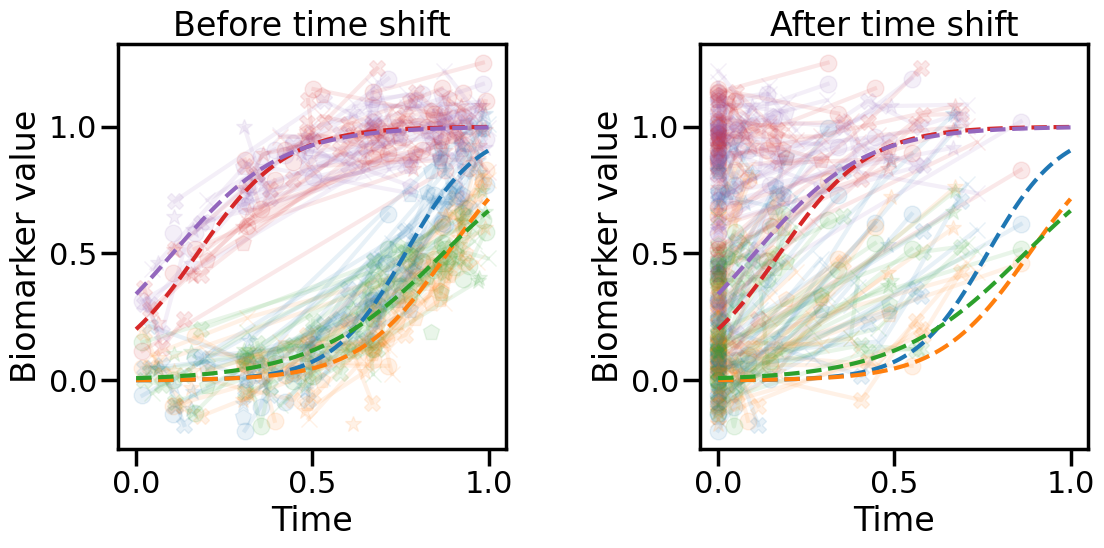

In [4]:
fig_data, axes = plt.subplots(ncols=2, figsize=(12, 6))
for i_ax, ax in enumerate(axes):
    ax: plt.Axes

    for i_subject, (subject, df_subject) in enumerate(df.groupby("subject")):
        for i_biomarker, biomarker in enumerate(
            results_dict["settings"]["cols_biomarker"]
        ):
            ax.plot(
                (
                    df_subject[results_dict["settings"]["col_time"]]
                    + time_shifts[i_subject]
                    if i_ax == 0
                    else df_subject[results_dict["settings"]["col_time"]]
                ),
                df_subject[biomarker],
                marker="oXxp*"[i_subject % 5],
                color=f"C{i_biomarker}",
                alpha=0.1,
            )

    for i_biomarker, (k, x0) in enumerate(zip(k_values, x0_values)):
        t = np.linspace(0, 1, 100)
        y = 1 / (1 + np.exp(-k * (t - x0)))
        ax.plot(t, y, color=f"C{i_biomarker}", linestyle="--", alpha=1)

    ax.set_xlabel(TIME_LABEL)
    ax.set_ylabel(BIOMARKER_LABEL)

axes[0].set_title("Before time shift")
axes[1].set_title("After time shift")
fig_data.tight_layout()

In [63]:
save_fig(fig_data, f"{TAG}-data")

Saved figure to /data/origami/michelle/projects/fl-prog/results/2025_10_13/non_overlapping_t0-data.png


===== k values =====
[9.601 7.863 5.434 7.895 6.395]
[9.76  8.938 4.945 8.328 6.969]
===== x0 values =====
[0.764 0.883 0.871 0.174 0.104]
[ 0.132  0.247  0.26  -0.431 -0.508]
===== x value offsets =====
[0.632 0.636 0.611 0.605 0.612]
===== x value offset std =====
0.012333192914882945
===== time shifts =====
[0.927 0.309 0.202 0.303 0.48  0.673 0.743 0.32  0.668 0.303 0.308 0.344
 0.874 0.778 0.841 0.018 0.109 0.49  0.203 0.616 0.945 0.488 0.045 0.791
 0.162 0.71  0.653 0.769 0.485 0.157 0.673 0.041 0.924 0.741 0.062 0.503
 0.184 0.527 0.861 0.467 0.445 0.484 0.625 0.826 0.877 0.422 0.579 0.685
 0.836 0.307 0.166 0.022 0.408 0.528 0.106 0.106 0.615 0.91  0.75  0.322]
[]
===== sigma =====
[0.1, 0.1, 0.1]
0.09553118050098419
===== k values =====
[9.601 7.863 5.434 7.895 6.395]
[9.808 8.984 4.907 8.593 6.875]
===== x0 values =====
[0.764 0.883 0.871 0.174 0.104]
[-0.078  0.038  0.051 -0.633 -0.708]
===== x value offsets =====
[0.842 0.845 0.82  0.808 0.811]
===== x value offset std ====

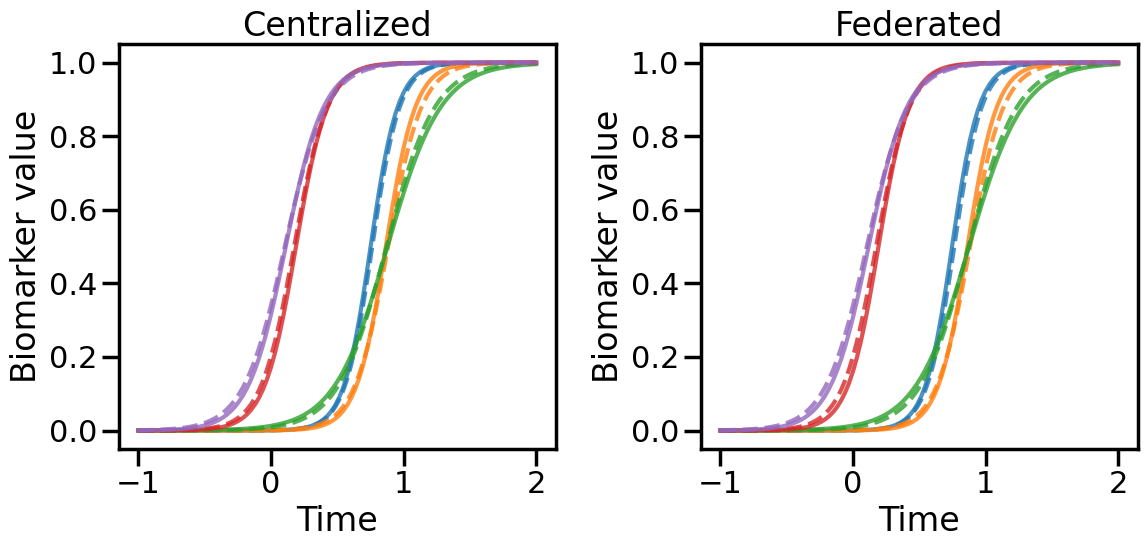

In [5]:
import warnings
from typing import Optional

import torch


def check_model_fit(
    estimated_k_values,
    estimated_x0_values,
    estimated_time_shifts,
    estimated_sigma,
    align_x=False,
    ax: Optional[plt.Axes] = None,
):
    if ax is None:
        _, ax = plt.subplots()

    estimated_k_values = np.array(estimated_k_values)
    estimated_x0_values = np.array(estimated_x0_values)
    estimated_time_shifts = np.array(estimated_time_shifts)
    estimated_sigma = np.array(estimated_sigma)

    mean_x_value_difference = (x0_values - estimated_x0_values).mean()

    for i_biomarker, (k, x0) in enumerate(zip(k_values, x0_values)):

        # ground truth
        t = np.linspace(-1, 2, 100)
        y = 1 / (1 + np.exp(-k * (t - x0)))
        ax.plot(t, y, color=f"C{i_biomarker}", linestyle="--", alpha=0.8)

        if align_x:
            offset = mean_x_value_difference
        else:
            offset = 0.0

        # simulations
        y_pred = torch.sigmoid(
            torch.tensor(
                estimated_k_values[i_biomarker]
                * (t - offset - estimated_x0_values[i_biomarker])
            )
        ).numpy()
        ax.plot(
            t,
            y_pred,
            color=f"C{i_biomarker}",
            linestyle="-",
            alpha=0.8,
        )

        ax.set_xlabel(TIME_LABEL)
        ax.set_ylabel(BIOMARKER_LABEL)

    print("===== k values =====")
    print(k_values)
    print(estimated_k_values)
    print("===== x0 values =====")
    print(x0_values)
    print(estimated_x0_values)
    print("===== x value offsets =====")
    print(x0_values - estimated_x0_values)
    print("===== x value offset std =====")
    print((x0_values - estimated_x0_values).std())
    print("===== time shifts =====")
    print(time_shifts)
    print(estimated_time_shifts)
    if len(estimated_time_shifts) > 0:
        print("===== time shift offset std =====")
        if len(time_shifts) < len(estimated_time_shifts):
            warnings.warn(
                "Number of estimated time shifts is larger than the number of true time "
                "shifts. Clipping estimated time shifts."
            )
            estimated_time_shifts = estimated_time_shifts[: len(time_shifts)]

        print((time_shifts - estimated_time_shifts).std())
    print("===== sigma =====")
    print(sigmas)
    print(estimated_sigma)


fig_model_fit, axes = plt.subplots(figsize=(12, 6), ncols=2)

for ax, setup in zip(axes, ["centralized", "federated"]):
    check_model_fit(
        **results_dict["results"][setup],
        align_x=True,
        ax=ax,
    )
    ax.set_title(setup.capitalize())

fig_model_fit.tight_layout()

In [65]:
save_fig(fig_model_fit, f"{TAG}-model_fit")

Saved figure to /data/origami/michelle/projects/fl-prog/results/2025_10_13/non_overlapping_t0-model_fit.png
